# GWAS with the 1000 Genomes TileDB-VCF Dataset

In this notebook we'll perform a rudimentary genome-wide association study using the 1000 Genomes (1KG) dataset. The goal of this tutorial is to demonstrate the mechanics of performing genome-wide analyses using variant call data stored with TileDB-VCF and how such analyses can be easily scaled using TileDB Cloud's serverless computation platform.

To get started we'll load a few required packages and define several variables that we'll refer to throughout the notebook.

# Setup

## Packages

In [1]:
import tiledb
import tiledbvcf
import tiledb.cloud
from tiledb.cloud.compute import Delayed

import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

print(
    f"tileDB-vcf v{tiledbvcf.version}\n"
    f"tileDB-cloud v{tiledb.cloud.version.version}"
)

tileDB-vcf v0.22.1.dev27
tileDB-cloud v0.10.0


## Variables

In [2]:
# variables
genome = "hg19"
array_uri = "tiledb://TileDB-Inc/vcf-1kg-phase3"
sample_array = "tiledb://TileDB-Inc/vcf-1kg-sample-metadata"

# vcf attributes to include
attrs = [
    "sample_name", 
    "contig",
    "pos_start",
    "pos_end", 
    "fmt_GT"
]

In [3]:
!tiledbvcf stat --uri tiledb://TileDB-Inc/vcf-1kg-phase3

/bin/bash: line 1: tiledbvcf: command not found


# Sample Phenotypes

Because no phenotypic data was collected for the 1KG dataset, we'll create a dummy trait indicating whether or not a sample identified as female.

In [4]:
with tiledb.open(sample_array) as A:
    df_samples = A.df[:]
    
# dummy trait
df_samples["is_female"] = df_samples.gender == "female"
df_samples

,pop,super_pop,gender,is_female
sampleuid,,,,
HG00096,GBR,EUR,male,False
HG00097,GBR,EUR,female,True
HG00099,GBR,EUR,female,True
HG00100,GBR,EUR,female,True
HG00101,GBR,EUR,male,False
...,...,...,...,...
NA21137,GIH,SAS,female,True
NA21141,GIH,SAS,female,True
NA21142,GIH,SAS,female,True


# Scaling GWAS with Serverless UDFs

We can parallelize the association analysis by dividing the genome into disjoint partitions that are queried, filtered, and analyzed by separate serverless nodes.

# Binned Genomic Regions

To get started we'll use the [`genome_windows`](https://cloud.tiledb.com/udfs/details/aaronwolen/genome_windows) UDF to divide a genome into windows (i.e., bins) and return a list of regions in the `chr:start-end` format that `tiledbvcf` expects.

In [5]:
bed_regions = tiledb.cloud.udf.exec(
    func = "aaronwolen/genome_windows", 
    genome = "hg19", 
    window = 100000,
    style = "NCBI",
)

For now we'll filter this list to include only regions from chromosome 20.

In [6]:
bed_regions = [r for r in bed_regions if r.startswith("20:")]
print(f"{len(bed_regions)} total regions")
bed_regions[:5]

631 total regions


['20:1-100000',
 '20:100001-200000',
 '20:200001-300000',
 '20:300001-400000',
 '20:400001-500000']

# GWAS Steps

Each of the individual tasks we performed above must be wrapped in functions so they can be packaged as UDFs and shipped to the serverless compute infrastructure. We'll define two separate functions:

## 1. `vcf_snp_query()`

- queries a specified window from the genome
- filters the sites based on the defined criteria

In [7]:
%%time
res = tiledb.cloud.udf.exec(
    func = "aaronwolen/vcf_snp_query",
    uri = array_uri,
    attrs = attrs,
    regions = bed_regions[:2],
)

res.to_pandas()

CPU times: user 94.3 ms, sys: 62.6 ms, total: 157 ms
Wall time: 9.48 s


,sample_name,contig,pos_start,pos_end,fmt_GT
0,HG00097,20,60828,60828,"[0, 1]"
1,HG00101,20,61098,61098,"[0, 1]"
2,HG00103,20,61098,61098,"[1, 0]"
3,HG00109,20,61098,61098,"[0, 1]"
4,HG00111,20,61098,61098,"[0, 1]"
...,...,...,...,...,...
577809,NA21142,20,195696,195696,"[1, 1]"
577810,NA21143,20,195696,195696,"[1, 1]"
577811,NA21144,20,195696,195696,"[1, 1]"
577812,NA21142,20,196604,196604,"[0, 1]"


## 2. [`filter_variants()`](https://cloud.tiledb.com/udfs/details/aaronwolen/filter_variants)

- calculates allele count and minor allele frequencies
- optinally filters for variants using the `maf` threshold

In [8]:
%%time
res2 = tiledb.cloud.udf.exec(
    func = "aaronwolen/filter_variants", 
    df = res,
    maf = (0.05, 0.95),
)

res2.to_pandas()

CPU times: user 183 ms, sys: 108 ms, total: 292 ms
Wall time: 7.69 s


sample_name  pos_end  fmt_GT  dose
contig pos_start                                   
20     61098         HG00101    61098  [0, 1]     1
       61098         HG00103    61098  [1, 0]     1
       61098         HG00109    61098  [0, 1]     1
       61098         HG00111    61098  [0, 1]     1
       61098         HG00115    61098  [1, 0]     1
...                      ...      ...     ...   ...
       195696        NA21142   195696  [1, 1]     2
       195696        NA21143   195696  [1, 1]     2
       195696        NA21144   195696  [1, 1]     2
       196604        NA21142   196604  [0, 1]     1
       196604        NA21144   196604  [1, 0]     1

[488449 rows x 4 columns]

## 3. `calc_gwas()` 

Reshapes the Dataframe of variants into a variant by sample matrix and performs a chi-squared analysis on site for the included trait



In [9]:
%%time
res3 = tiledb.cloud.udf.exec(
    func = "aaronwolen/calc_gwas",
    df = res2,
    trait = df_samples.is_female,
)

res3.to_pandas()

CPU times: user 90.5 ms, sys: 23 ms, total: 113 ms
Wall time: 9.66 s


,contig,pos_start,oddsratio,pvalue
0,20,61098,0.494083,0.482112
1,20,61138,0.289018,0.590851
2,20,61795,0.068686,0.793260
3,20,63231,0.851720,0.356066
4,20,63244,0.004420,0.946994
...,...,...,...,...
423,20,198965,0.150694,0.697873
424,20,198977,0.025577,0.872937
425,20,199078,0.000250,0.987379
426,20,199114,0.000250,0.987379


## 4. `combine_results()`

- creates a single dataframe containing individual results from each partition

In [10]:
def combine_results(dfs):
    """
    Combine GWAS Results

    :param list of dataframes: Region-specific GWAS results to combine
    """
    import pyarrow as pa
    print(f"Input list contains {len(dfs)} Arrow tables")
    out = pa.concat_tables([x for x in dfs if x is not None])
    return out

# Construct UDF-based Task Graph

To run the complete pipeline serverlessly we need to create Delayed versions of these functions with the appropriate parameters. For `query_region()` we need to create one delayed instance for each of the genomic regions to be queried in parallel.

In [11]:
nregions = len(bed_regions[:100])
nparts = nregions // 5
print(f"Analyzing {nregions} regions across {nparts} partitions")

delayed_queries = []
for i in range(nparts):
    delayed_queries.append(
        Delayed(
            "aaronwolen/vcf_snp_query",
            result_format=tiledb.cloud.UDFResultType.ARROW,
            name=f"VCF SNP Query {i}",
        )(
            uri=array_uri,
            attrs=attrs,
            regions=bed_regions[:nregions],
            region_partition=(i, nparts),
            memory_budget_mb=1024,
        )
    )

delayed_filters = [
    Delayed("aaronwolen/filter_variants", name=f"VCF Filter {i[0]}")(
        df=i[1], maf=(0.05, 0.95)
    )
    for i in enumerate(delayed_queries)
]

delayed_gwas = [
    Delayed("aaronwolen/calc_gwas", name=f"VCF GWAS {i[0]}")(
        df=i[1], trait=df_samples.is_female
    )
    for i in enumerate(delayed_filters)
]

delayed_results = Delayed(combine_results, local=True)(delayed_gwas)
delayed_results.visualize()

Analyzing 100 regions across 20 partitions


FigureWidget({
    'data': [{'hoverinfo': 'none',
              'line': {'color': '#888', 'width': 0.5},
              'mode': 'lines',
              'type': 'scatter',
              'uid': '3cfcce19-017b-4263-b647-acc2fcb7d061',
              'x': [125.59, 2054.6, None, 119.59, 125.59, None, 93.592, 119.59,
                    None, 482.59, 2054.6, None, 324.59, 482.59, None, 298.59,
                    324.59, None, 741.59, 2054.6, None, 529.59, 741.59, None,
                    503.59, 529.59, None, 951.59, 2054.6, None, 734.59, 951.59,
                    None, 708.59, 734.59, None, 1136.6, 2054.6, None, 939.59,
                    1136.6, None, 913.59, 939.59, None, 1309.6, 2054.6, None,
                    1144.6, 1309.6, None, 1118.6, 1144.6, None, 1476.6, 2054.6,
                    None, 1349.6, 1476.6, None, 1323.6, 1349.6, None, 1640.6,
                    2054.6, None, 1554.6, 1640.6, None, 1528.6, 1554.6, None,
                    1803.6, 2054.6, None, 1759.6, 1803.6, None

Finally, we can execute our distributed GWAS and collect the results.

In [12]:
%%time
results = delayed_results.compute(name="GWAS Tutorial")

Input list contains 20 Arrow tables
CPU times: user 18.4 s, sys: 11.7 s, total: 30.1 s
Wall time: 3min 11s


In [13]:
results.to_pandas()

,contig,pos_start,oddsratio,pvalue
0,20,61098,0.494083,0.482112
1,20,61138,0.289018,0.590851
2,20,61795,0.068686,0.793260
3,20,63231,0.851720,0.356066
4,20,63244,0.004420,0.946994
...,...,...,...,...
30836,20,9999302,1.173945,0.278592
30837,20,9999622,1.173945,0.278592
30838,20,9999661,1.173945,0.278592
30839,20,9999900,0.999755,0.317370


And no association test would be complete without a manhattan plot:

[Text(0.5, 0, 'Chr 1 Position'), Text(0, 0.5, '-log10 p-value')]

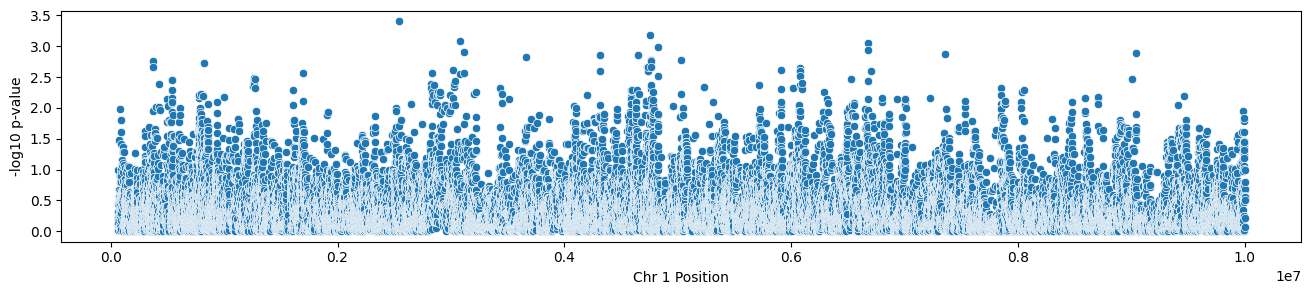

In [14]:
results = results.to_pandas()
results["log_pvalue"] = -np.log10(results.pvalue)

plt.figure(figsize = (16, 3))

ax = sns.scatterplot(
    x = "pos_start", 
    y = "log_pvalue", 
    data = results
)

ax.set(xlabel = "Chr 1 Position", ylabel = "-log10 p-value")

## Summary

Here we've demonstrated how genome-wide pipelines can be encapsulated as distinct tasks, distributed as UDFs, and easily deployed in parallel at scale.